In [1]:
# System path setup
import os
import sys

print('Project root location in: \n' + os.path.abspath('')[:-9])

data_filepath = os.path.abspath('')[:-9] + '/data/'
sys.path.insert(0, os.path.abspath('')[:-9] + '/modules/')

Project root location in: 
/Users/leonardoyamaguishi/Documents/Udacity/data_science_capstone_project/


In [2]:
# Importing libraries for Data Handling and EDA
import pandas as pd
import numpy as np
import scipy
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from apriori_python import apriori

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Modules created based on the EDA and ETL steps
from modelling_support import prioritize_and_drop_redundant_columns
from modelling_support import above_median_metric

# Libraries for Data Mining
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


# Model evaluation libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Proposed Data mining worflow

**Feature Selection:** Using Ada Boost Classifier to determine the most relevant features for the desired classification, based on the way that this classifier gives higher relevancy to splits that result in lower Gini Indices, while decreasing possible bias by considering previous misclassifications throughout its iterations.

**Data Mining:** Based on the features selected using the Ada Boost Classifier, a Random Forest Classifier will be trained to have a higher potential of generalization on the training data, in order to assess the possibility of predicting the overall performance of a listing using only the data in its front page, disconsidering the comments.

In [3]:
# Reading data and joining a dataset with the assayed parameters
amenities = pd.read_csv(data_filepath + 'amenities_post_etl.csv', index_col = 0)
listings = pd.read_csv(data_filepath + 'listings_post_etl.csv', index_col = 0)

filtered_amenities = prioritize_and_drop_redundant_columns(amenities, 0.8, 40)

df = listings.join(filtered_amenities)
df = above_median_metric(df)
df.dropna(inplace = True)

df.head()

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,...,amn_linen,amn_microwave,amn_stove,amn_hair,amn_coffee,amn_oven,amn_standard,amn_fire,amn_blanket,above_median
0,17878,68997,1.0,1.0,0,1,1,5,2.0,2.0,...,1,1,1,1,1,1,1,0,0,1
1,24480,99249,4.0,1.0,0,1,1,2,1.0,1.0,...,1,1,0,1,1,0,1,0,1,1
2,25026,102840,3.0,0.8,0,1,1,3,1.0,1.0,...,1,1,1,1,1,1,1,0,0,1
3,35636,153232,1.0,1.0,1,1,1,2,1.0,1.0,...,1,1,1,1,1,1,1,0,0,1
4,35764,153691,1.0,1.0,1,1,1,2,1.0,1.0,...,1,1,1,1,1,0,1,1,1,1


In [4]:
# Dropping columns not considered for modelling and colinear features, such as human_development_index
df.drop(['id',
         'human_development_index',
         'host_id',
         'reviews_per_month',
         'human_development_index',
         'host_days_since_start', # Removed due to survivor bias
         'host_response_time', # Removed due to survivor bias
         'host_response_rate', # Removed due to survivor bias
         'host_is_superhost', # Removed due to survivor bias
         'neighbourhood_key'],
        axis = 1,
        inplace = True)

# Listing the input columns to filter the DataFrame
input_columns = []

for column in df.columns:
    if column != 'above_median':
        input_columns.append(column)

# Splitting the dataset in train and test datasets
df_train, df_test = train_test_split(df, test_size = 0.3, train_size = 0.7,random_state = 123)

# Retrieving the dataset values as np.arrays to process the data on sklearn
X_train = df_train[input_columns].values
y_train = df_train['above_median'].values

## Feature selection: ADA Boosting Classifier

In [5]:
# Defining a decision stomp (Decision Tree with max_depth = 1) for the Ada Boost Classifier
decision_stomp = DecisionTreeClassifier(criterion = 'gini',
                                          splitter = 'best',
                                          max_depth = 1,
                                          random_state = 123)

In [6]:
def cross_validation_score_lists(model_for_cv, X_train, y_train):
    '''
    INPUTS:
    model_for_cf - sklearn estimator to be evaluated using 5-fold cross validation
    X_train - nd.array with the prediction data from the train dataset
    y_train - array with the output data from the train dataset

    OUTPUTS:
    cv_score_list - (list) of with 10 train and validation scores
    cv_score_type_list - (list) of score types, 5 for train and 5 for validation
    '''
    
    cv_results = cross_validate(model_for_cv,
                                X_train,
                                y = y_train,
                                return_estimator = True,
                                return_train_score = True)
    
    # By standard the cross validator performs a 5-fold cross validation
    
    # Storing the results in a DataFrame with the columns n_estimators, score and score_type
    # The idea is to be able to visualize the confidence interval of the scores
    # Inspiration: https://stackabuse.com/seaborn-line-plot-tutorial-and-examples/
    
    cv_score_list = []
    cv_score_type_list = []
    
    for i in range(0,5):
        cv_score_list.append(cv_results['train_score'][i])
        cv_score_type_list.append('train')

        
    for i in range(0,5):
        cv_score_list.append(cv_results['test_score'][i])
        cv_score_type_list.append('test')
    
    return cv_score_list, cv_score_type_list

In [7]:
def evaluate_classification(y_real, y_prediction):
    '''
    INPUTS: 
    y_real - (array) of output boolean [0, 1] original values from a given dataset 
    y_prediction - (array) of output boolean [0, 1] predicted values from a given dataset
    
    OUTPUTS:
    none
    
    Prints the Confusion Matrix based on the given inputs
    '''
    
    acc = accuracy_score(y_real, y_prediction)
    print('Train dataset accuracy: {}'.format(acc))
    
    c_m = confusion_matrix(y_real, y_prediction)


    label_0_0 = "True Negative:\n " + str(round((100*c_m[0,0])/c_m.sum(),1)) + '%'
    label_0_1 = "False Positive:\n " + str(round((100*c_m[0,1])/c_m.sum(),1)) + '%'
    label_1_0 = "False Negative:\n " + str(round((100*c_m[1,0])/c_m.sum(),1)) + '%'
    label_1_1 = "True Positive:\n " + str(round((100*c_m[1,1])/c_m.sum(),1)) + '%'

    labels = [[label_0_0, label_0_1],[label_1_0, label_1_1]]

    fig = plt.figure(figsize = (8,8))
    sns.heatmap(c_m, annot = labels, fmt = '', cmap = 'Blues')
    
    return 

<AxesSubplot:xlabel='n_estimators', ylabel='score'>

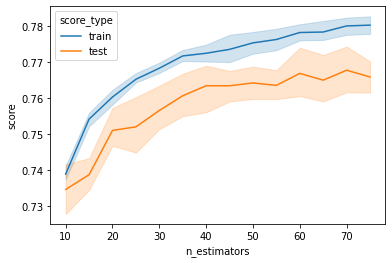

In [8]:
# Evaluating the n_estimators from the Ada Boost Classifier using cross validation
n_estimator_count  = []
score_list = []
score_type_list = []

# Evaluating the n_estimators using cross validation
for n_estimators in range(10,80, 5):
    gradient_boosting_classifier = AdaBoostClassifier(base_estimator = decision_stomp,
                                                      n_estimators = n_estimators,
                                                      random_state = 123)
    
    cv_score_list, cv_score_type_list = cross_validation_score_lists(gradient_boosting_classifier,
                                                                     X_train,
                                                                     y_train)
    
    n_estimator_count = n_estimator_count + ([n_estimators]*10)
    score_list = score_list + cv_score_list
    score_type_list = score_type_list + cv_score_type_list

score_df = pd.DataFrame({'n_estimators': n_estimator_count,
                         'score' : score_list,
                         'score_type' : score_type_list})
    
# Plotting the results from the Random Forest Classifier
sns.lineplot(x = 'n_estimators', y = 'score', hue = 'score_type', data = score_df, ci = 95)

In [9]:
# As the dispersion of the score for the test data seems to be smaller for 20 estimators
# The chosen approach was to focus on the Ada Boost Classifier using 20 estimators
gradient_boosting_classifier = AdaBoostClassifier(base_estimator = decision_stomp,
                                                  n_estimators = 20,
                                                  random_state = 123)

cv_results = cross_validate(gradient_boosting_classifier,
                            X_train,
                            y = y_train,
                            return_estimator = True,
                            return_train_score = True)


feature_importance_df = []

# Assessing each developed estimator
for i in range(0,5):
    # Retrieving its feature importances
    feature_importance_df.append(cv_results['estimator'][i].feature_importances_)

feature_importance_df = pd.DataFrame(feature_importance_df, columns = input_columns)
feature_importance_series = feature_importance_df.mean(axis = 0).sort_values(ascending = False)

In [10]:
feature_importance_series[feature_importance_series > 0]

review_scores_checkin          0.12
review_scores_value            0.11
review_scores_location         0.08
minimum_nights_avg_ntm         0.08
review_scores_cleanliness      0.07
amn_linen                      0.06
entire_home_apt                0.05
review_scores_communication    0.05
amn_microwave                  0.05
maximum_nights_avg_ntm         0.05
amn_standard                   0.05
host_identity_verified         0.05
amn_elevator                   0.05
bathroom_qty                   0.04
amn_free                       0.03
review_scores_accuracy         0.02
amn_wifi                       0.02
amn_hair                       0.01
bedrooms                       0.01
dtype: float64

### Feature Selection: dataset subset assessment using the train dataset

Train dataset accuracy: 0.7537537537537538


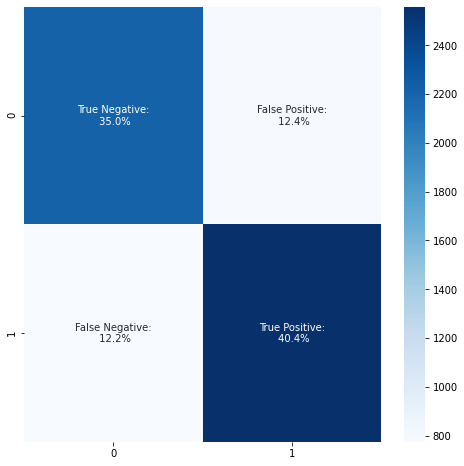

In [11]:
# Assessing the chosen n_estimators using a confusion matrix
evaluated_model = AdaBoostClassifier(base_estimator = decision_stomp, 
                                     n_estimators = 20,
                                     random_state = 123)

# Splitting the train set in training and validation
# Attempting to create a 'local' dataset (subset) to evaluate the selected features using a confusion matrix
X_train_eval, X_val_eval, y_train_eval, y_val_eval = train_test_split(X_train, y_train,
                                                                      test_size = 0.3,
                                                                      train_size = 0.7,
                                                                      random_state = 123)
# Training
evaluated_model.fit(X_train_eval, y_train_eval)

# Predicting for the local train dataset
y_eval_predicted = evaluated_model.predict(X_train_eval)

# Plotting the confusion matrix for the train dataset
evaluate_classification(y_train_eval, y_eval_predicted)

Train dataset accuracy: 0.7536873156342183


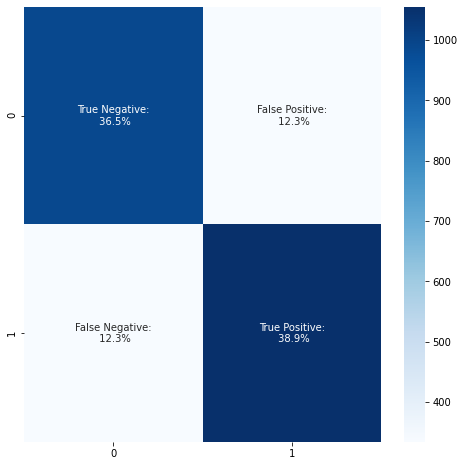

In [12]:
# Predicting the y values the local assessment dataset
y_val_eval_predicted = evaluated_model.predict(X_val_eval)
# Plotting the predicted y values from the local assessment dataset
evaluate_classification(y_val_eval, y_val_eval_predicted)

## Data Mining: Random Forest Classifier

In [18]:
# Selecting the features based on the ADA Boost
selected_features = feature_importance_series[feature_importance_series > 0].index

# Redefining the train and test dataset based on the selected features
X_train = df_train[selected_features].values
X_test = df_test[selected_features].values

y_test = df_test['above_median'].values

<AxesSubplot:xlabel='n_estimators', ylabel='score'>

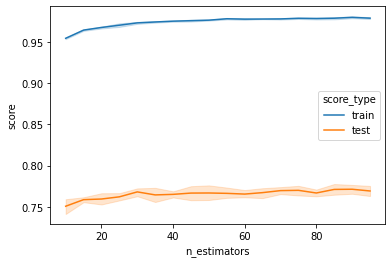

In [14]:
n_estimator_count = []
score_list = []
score_type_list = []

for n_estimators in range(10, 100, 5):
    
    generic_rfc = RandomForestClassifier(min_samples_split = 5, # Selected 5 to avoid overfitting
                                         n_estimators = n_estimators) 
    
    cv_score_list, cv_score_type_list = cross_validation_score_lists(generic_rfc,
                                                                     X_train,
                                                                     y_train)
    
    n_estimator_count = n_estimator_count + ([n_estimators]*10)
    score_list = score_list + cv_score_list
    score_type_list = score_type_list + cv_score_type_list

score_df = pd.DataFrame({'n_estimators': n_estimator_count,
                         'score' : score_list,
                         'score_type' : score_type_list})
    
# Plotting the results from the Random Forest Classifier
sns.lineplot(x = 'n_estimators', y = 'score', hue = 'score_type', data = score_df, ci = 95)

Train dataset accuracy: 0.7592654054652064


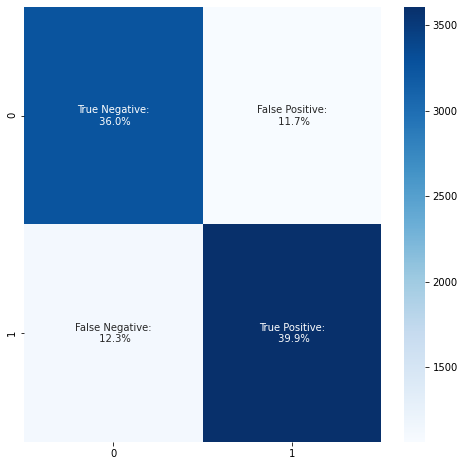

In [16]:
chosen_rfc = RandomForestClassifier(min_samples_split = 5, # Selected 5 to avoid overfitting
                                    n_estimators = 20,
                                    random_state = 123)

# Training
evaluated_model.fit(X_train, y_train)

# Predicting for the local train dataset
y_predicted = evaluated_model.predict(X_train)

# Plotting the confusion matrix for the train dataset
evaluate_classification(y_train, y_predicted)

Train dataset accuracy: 0.7570986060918947


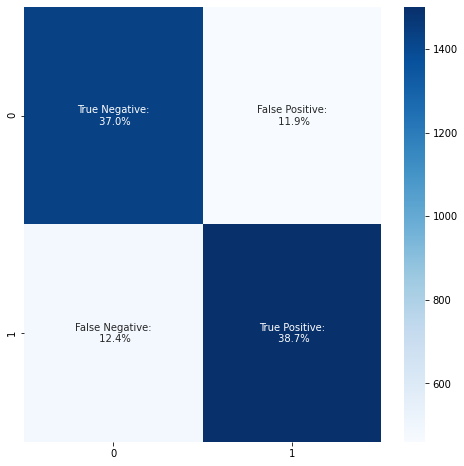

In [19]:
# Predicting for the local train dataset
y_predicted = evaluated_model.predict(X_test)

# Plotting the confusion matrix for the train dataset
evaluate_classification(y_test, y_predicted)